Simple gradient-based quadratic classification model to compute $W$. 

I suspect we'd get very little out of going for something non-linear or higher dimension. We're already getting almost no change on the off-diagonals, so probably not a whole lot going on beyond pairwise interactions.

Positive class performance is poor. Oversampling positive synthetic examples doesn't do much. May get better with real data, since pulling from YC, a16z, etc.

In [31]:
! pip install torch scikit-learn matplotlib -q

In [32]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import seaborn as sns

sys.path.append('..')
from src.model import initialize_weight_matrix

np.set_printoptions(precision=2, suppress=True, linewidth=120)


In [33]:
config = {
    'data_path': '../data/synth/encoded_founders_composites.csv',  
    'target_column': 'success',     
    'test_size': 0.2,
    'val_size': 0.25,
    'random_state': 4,
    'batch_size': 64,
    'lr': 0.001,
    'weight_decay': 1e-2,
    'epochs': 200,
    'patience': 10,
    'lr_decay_factor': 0.5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

In [34]:
df = pd.read_csv(config['data_path'])

feature_columns = df.columns[:-3] 

X = df[feature_columns].to_numpy()
X = StandardScaler().fit_transform(X)
y = df[config['target_column']].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=config['test_size'], random_state=config['random_state'], shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=config['val_size'], random_state=config['random_state'], shuffle=True
)

# Convert data to tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor   = torch.FloatTensor(X_val)
y_val_tensor   = torch.FloatTensor(y_val)
X_test_tensor  = torch.FloatTensor(X_test)
y_test_tensor  = torch.FloatTensor(y_test)

pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()])

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'])

# Lists to store training history
train_loss_history, val_loss_history, test_loss_history = [], [], []
train_acc_history, val_acc_history, test_acc_history = [], [], []


In [35]:
class QuadraticModel(nn.Module):
    def __init__(self, input_dim, rand_init=False):
        super(QuadraticModel, self).__init__()
        if rand_init:
            self.W = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        else:
            W_init = torch.FloatTensor(initialize_weight_matrix(input_dim))
        self.W = nn.Parameter(W_init)
        self.b = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        # Enforce symmetry in W
        W_sym = 0.5 * (self.W + self.W.t())
        scores = torch.sum(x * (x @ W_sym), dim=1)
        return scores  
    
    def get_W(self):
        return 0.5 * (self.W + self.W.t())

In [36]:
class QuadMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, rand_init=False):
        super().__init__()
        
        if rand_init:
            self.W = nn.Parameter(torch.randn(input_dim, input_dim) * 0.01)
        else:
            self.W = nn.Parameter(torch.FloatTensor(initialize_weight_matrix(input_dim)))
            
        self.nonlinear = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.b = nn.Parameter(torch.zeros(1))
        
    def forward(self, x):
        W_sym = 0.5 * (self.W + self.W.t())
        quad_scores = torch.sum(x * (x @ W_sym), dim=1, keepdim=True)
        nonlinear_scores = self.nonlinear(x)
        return (quad_scores + nonlinear_scores + self.b).squeeze()
    
    def get_W(self):
        return 0.5 * (self.W + self.W.t())


In [37]:
class ModelTrainer:
    def __init__(self, model, config):
        self.model = model.to(config['device'])
        self.config = config
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(config['device']))
        self.optimizer = torch.optim.AdamW(
            model.parameters(), 
            lr=config['lr'], 
            weight_decay=config['weight_decay']
        )
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.best_model_state = None
        
        self.train_loss_history = []
        self.val_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []
        self.test_acc_history = []
        
    def train_epoch(self, train_loader):
        self.model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(self.config['device'])
            y_batch = y_batch.to(self.config['device'])
            
            self.optimizer.zero_grad()
            outputs = self.model(X_batch)
            loss = self.criterion(outputs, y_batch)
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item() * X_batch.size(0)
            predicted = (outputs > 0).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            
        return epoch_loss / total, correct / total
    
    @torch.no_grad()
    def evaluate(self, X, y):
        self.model.eval()
        X = X.to(self.config['device'])
        y = y.to(self.config['device'])
        
        outputs = self.model(X)
        loss = self.criterion(outputs, y).item()
        acc = ((outputs > 0).float() == y).float().mean().item()
        
        return loss, acc
    
    def train(self, train_loader, X_val, y_val, X_test, y_test):
        for epoch in range(self.config['epochs']):
            train_loss, train_acc = self.train_epoch(train_loader)
            val_loss, val_acc = self.evaluate(X_val, y_val)
            test_loss, test_acc = self.evaluate(X_test, y_test)
            
            self.scheduler.step(val_loss)
            
            # Early stopping check
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                self.best_model_state = self.model.state_dict().copy()
            else:
                self.patience_counter += 1
                
            if self.patience_counter >= self.config['patience']:
                print(f'Early stopping at epoch {epoch}')
                # Restore best model
                self.model.load_state_dict(self.best_model_state)
                break
            
            self.train_loss_history.append(train_loss)
            self.val_loss_history.append(val_loss)
            self.test_loss_history.append(test_loss)
            self.train_acc_history.append(train_acc)
            self.val_acc_history.append(val_acc)
            self.test_acc_history.append(test_acc)
            
            self.scheduler.step(val_loss)
            
            if epoch % 5 == 0:
                print(f"Epoch {epoch}: "
                    f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Test Loss = {test_loss:.4f}, "
                    f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, Test Acc = {test_acc:.4f}")


In [38]:
input_dim = X_train.shape[1]
model = QuadMLP(input_dim, hidden_dim=32, rand_init=False)
# model = QuadraticModel(input_dim=input_dim)
W_init = model.W.clone().detach()  # Store initial weights

trainer = ModelTrainer(model, config)

# Train the model
trainer.train(
    train_loader,
    X_val_tensor,
    y_val_tensor,
    X_test_tensor,
    y_test_tensor
)

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor.to(config['device']))
    test_preds = (test_outputs > 0).int().cpu().numpy()

/Users/Viresh/Desktop/Spring 2025/Angel Network/founder-rank/venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 0: Train Loss = 54.5786, Val Loss = 51.2194, Test Loss = 51.8981, Train Acc = 0.3623, Val Acc = 0.3490, Test Acc = 0.3555
Epoch 5: Train Loss = 23.2754, Val Loss = 21.9232, Test Loss = 22.3479, Train Acc = 0.5415, Val Acc = 0.5565, Test Acc = 0.5690
Epoch 10: Train Loss = 10.4476, Val Loss = 9.2968, Test Loss = 10.3198, Train Acc = 0.7013, Val Acc = 0.7125, Test Acc = 0.7045
Epoch 15: Train Loss = 4.9854, Val Loss = 4.0731, Test Loss = 5.1553, Train Acc = 0.8150, Val Acc = 0.8300, Test Acc = 0.8230
Epoch 20: Train Loss = 3.6298, Val Loss = 2.7577, Test Loss = 3.7906, Train Acc = 0.8585, Val Acc = 0.8840, Test Acc = 0.8710
Epoch 25: Train Loss = 3.1564, Val Loss = 2.3629, Test Loss = 3.3034, Train Acc = 0.8710, Val Acc = 0.8965, Test Acc = 0.8815
Epoch 30: Train Loss = 2.7342, Val Loss = 2.0340, Test Loss = 2.8154, Train Acc = 0.8670, Val Acc = 0.8945, Test Acc = 0.8775
Epoch 35: Train Loss = 2.2166, Val Loss = 1.7295, Test Loss = 2.2989, Train Acc = 0.8592, Val Acc = 0.8970, Test

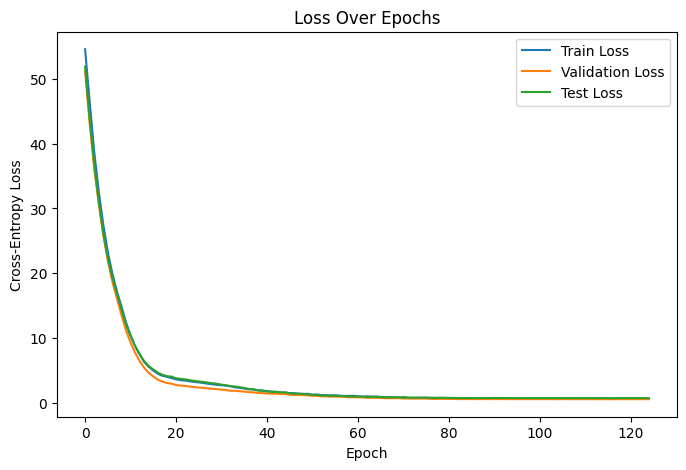

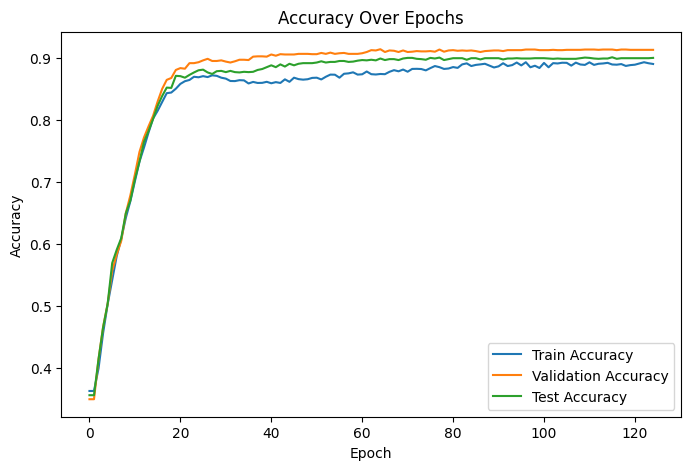

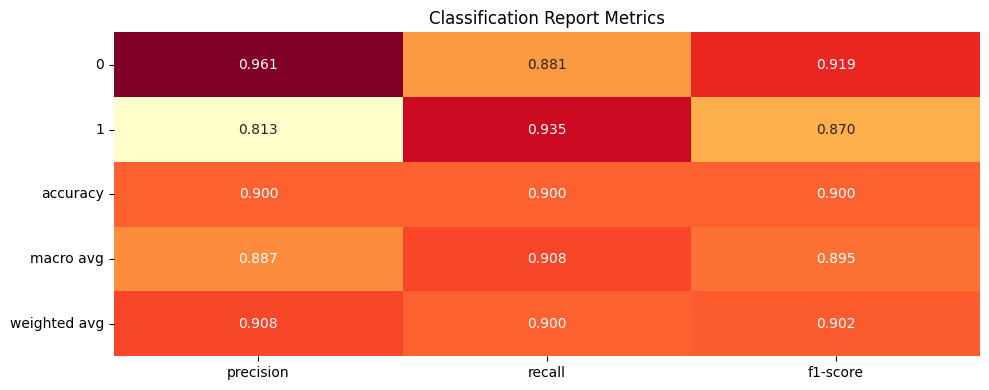

In [39]:
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_loss_history, label='Train Loss')
plt.plot(trainer.val_loss_history, label='Validation Loss')
plt.plot(trainer.test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(trainer.train_acc_history, label='Train Accuracy')
plt.plot(trainer.val_acc_history, label='Validation Accuracy')
plt.plot(trainer.test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

report = classification_report(y_test, test_preds, output_dict=True)
report_df = pd.DataFrame(report).round(3).T
report_df = report_df.drop('support', axis=1)  # Optional: remove support column

plt.figure(figsize=(10, 4))
sns.heatmap(report_df, annot=True, cmap='YlOrRd', fmt='.3f', cbar=False)
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.show()

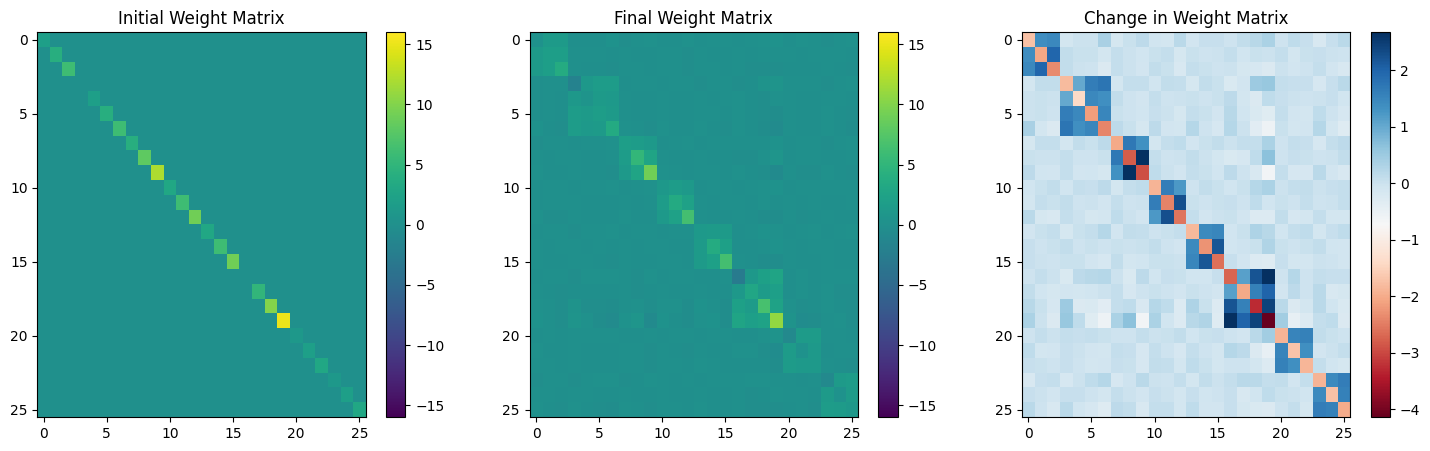

In [40]:
W_final = model.get_W().detach().cpu().numpy()
b_final = model.b.item()

vmin, vmax = -16, 16

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
im0 = axs[0].imshow(W_init.cpu().numpy(), aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[0].set_title("Initial Weight Matrix")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(W_final, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
axs[1].set_title("Final Weight Matrix")
plt.colorbar(im1, ax=axs[1])

W_diff = W_final - W_init.cpu().numpy()
im2 = axs[2].imshow(W_diff, aspect='auto', cmap='RdBu')
axs[2].set_title("Change in Weight Matrix")
plt.colorbar(im2, ax=axs[2])
plt.show()

In [41]:
# import pickle
# import re

# filename = '../models/26x26/W_1.pkl'
# new_filename = re.sub(r'(\d+)', lambda x: str(int(x.group(1)) + 1), filename, count=1)

# with open(new_filename, 'wb') as f:
#     pickle.dump(W, f)

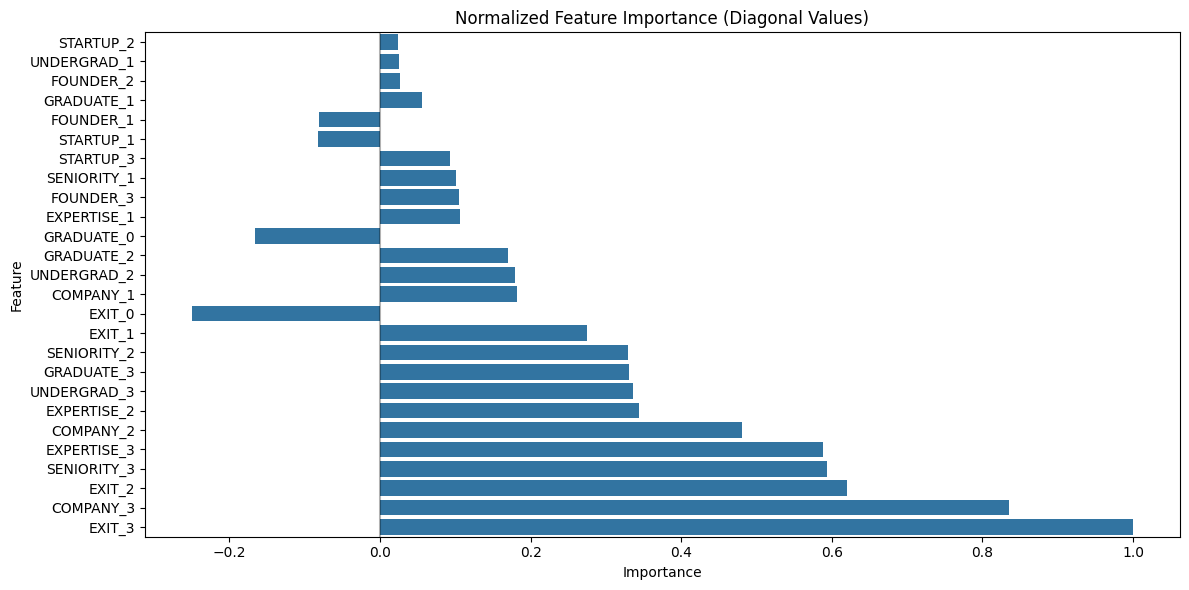

In [42]:
import seaborn as sns

# Get absolute values for feature importance (diagonal elements)
feature_importance = np.abs(np.diag(W_final))
feature_pairs = np.abs(W_final - np.diag(np.diag(W_final)))  # Off-diagonal elements

# Create feature names (assuming they match your input dimension)
feature_names = df[feature_columns].columns
# Get values for feature importance (diagonal elements)
feature_importance_abs = np.abs(np.diag(W_final))  # For sorting
feature_importance_real = np.diag(W_final)
feature_importance_normalized = feature_importance_real / np.max(np.abs(feature_importance_real))

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance_normalized,
    'Importance_abs': np.abs(feature_importance_normalized)
}).sort_values('Importance_abs', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df, y='Feature', x='Importance')
plt.title('Normalized Feature Importance (Diagonal Values)')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/0h/b0b6qlp97wxd6bw8pzg5jm280000gq/T/ipykernel_35636/3190557894.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_interactions,


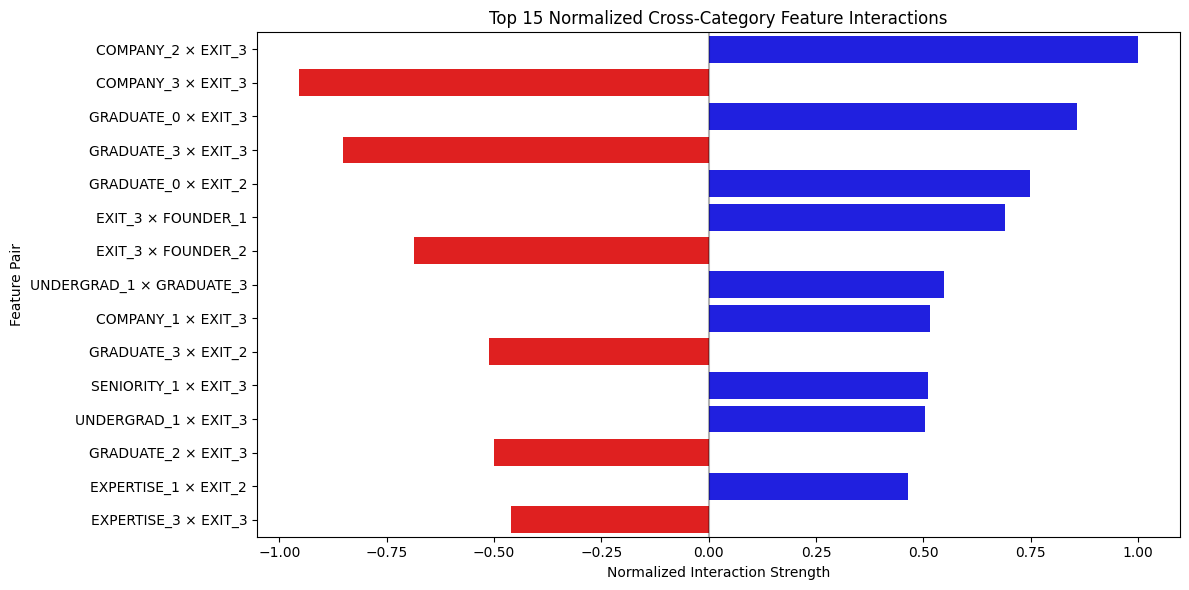

In [43]:
# Get feature category mappings
from src.config import cfg
MATRIX = cfg.MATRIX
category_map = {}
start_idx = 0
for cat in MATRIX:
    dim = MATRIX[cat]['DIMENSION']
    end_idx = start_idx + dim
    for i in range(start_idx, end_idx):
        category_map[feature_names[i]] = cat
    start_idx = end_idx

# Get the upper triangle of the matrix (excluding diagonal)
upper_triangle = np.triu(W_final, k=1)

# Get pairs of features and their interaction strengths (only different categories)
pairs = []
for i in range(len(upper_triangle)):
    for j in range(i+1, len(upper_triangle)):
        cat1 = category_map[feature_names[i]]
        cat2 = category_map[feature_names[j]]
        if cat1 != cat2:  # Only include pairs from different categories
            pairs.append((feature_names[i], feature_names[j], upper_triangle[i,j]))

# Convert to DataFrame and sort by absolute interaction strength

interactions_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', 'Interaction Strength'])
# Normalize interaction strengths
max_abs_interaction = np.max(np.abs(interactions_df['Interaction Strength']))
interactions_df['Interaction Strength'] = interactions_df['Interaction Strength'] / max_abs_interaction
interactions_df['Abs_Strength'] = np.abs(interactions_df['Interaction Strength'])
interactions_df = interactions_df.sort_values('Abs_Strength', ascending=False)

plt.figure(figsize=(12, 6))
top_n = 15
top_interactions = interactions_df.head(top_n)

colors = ['red' if x < 0 else 'blue' for x in top_interactions['Interaction Strength']]
sns.barplot(data=top_interactions, 
            y=top_interactions.apply(lambda x: f"{x['Feature 1']} × {x['Feature 2']}", axis=1),
            x='Interaction Strength',
            palette=colors)

plt.title(f'Top {top_n} Normalized Cross-Category Feature Interactions')
plt.xlabel('Normalized Interaction Strength')
plt.ylabel('Feature Pair')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

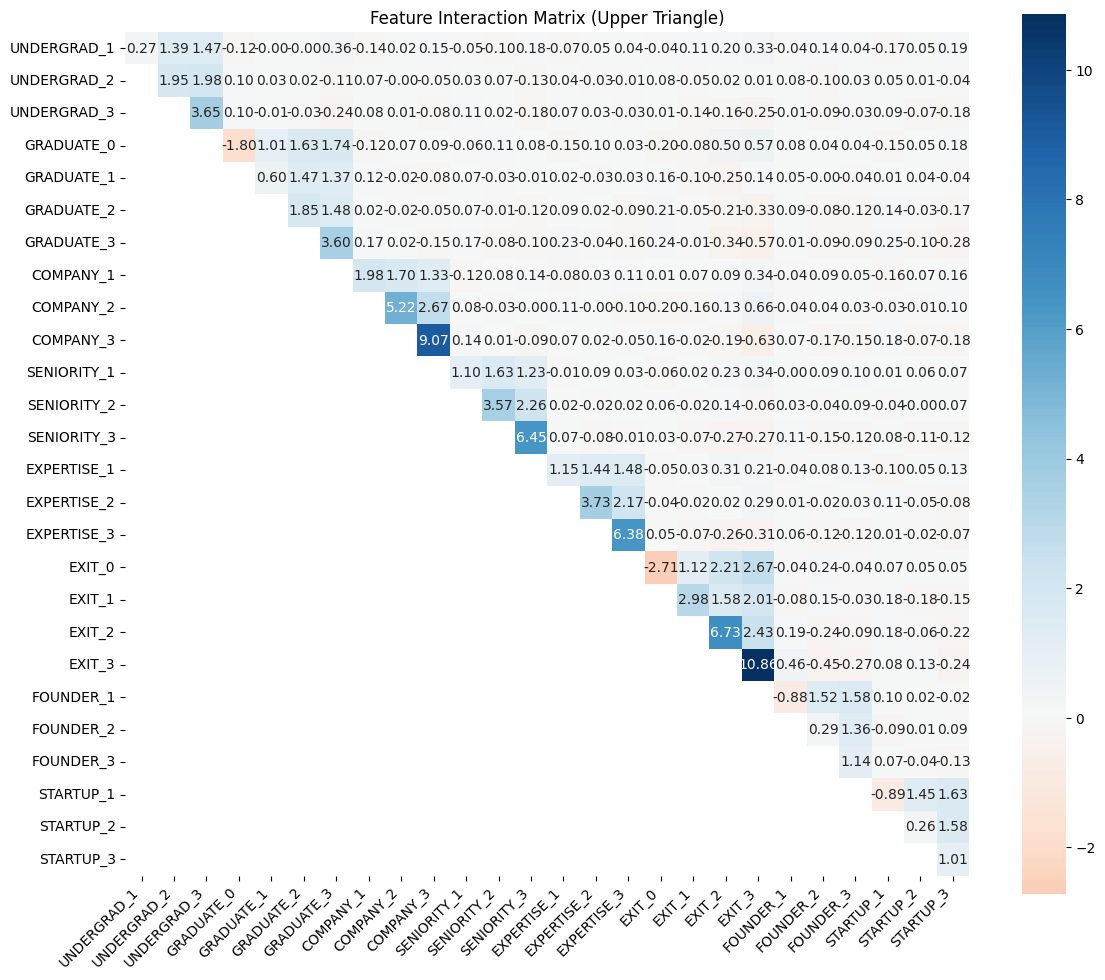

In [44]:
plt.figure(figsize=(12, 10))
mask = np.zeros_like(W_final)
mask[np.tril_indices_from(mask, k=-1)] = True  # Mask lower triangle since matrix is symmetric

sns.heatmap(W_final, 
            xticklabels=feature_names,
            yticklabels=feature_names,
            cmap='RdBu',
            center=0,
            mask=mask,
            annot=True,
            fmt='.2f',
            square=True)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Feature Interaction Matrix (Upper Triangle)')
plt.tight_layout()
plt.show()

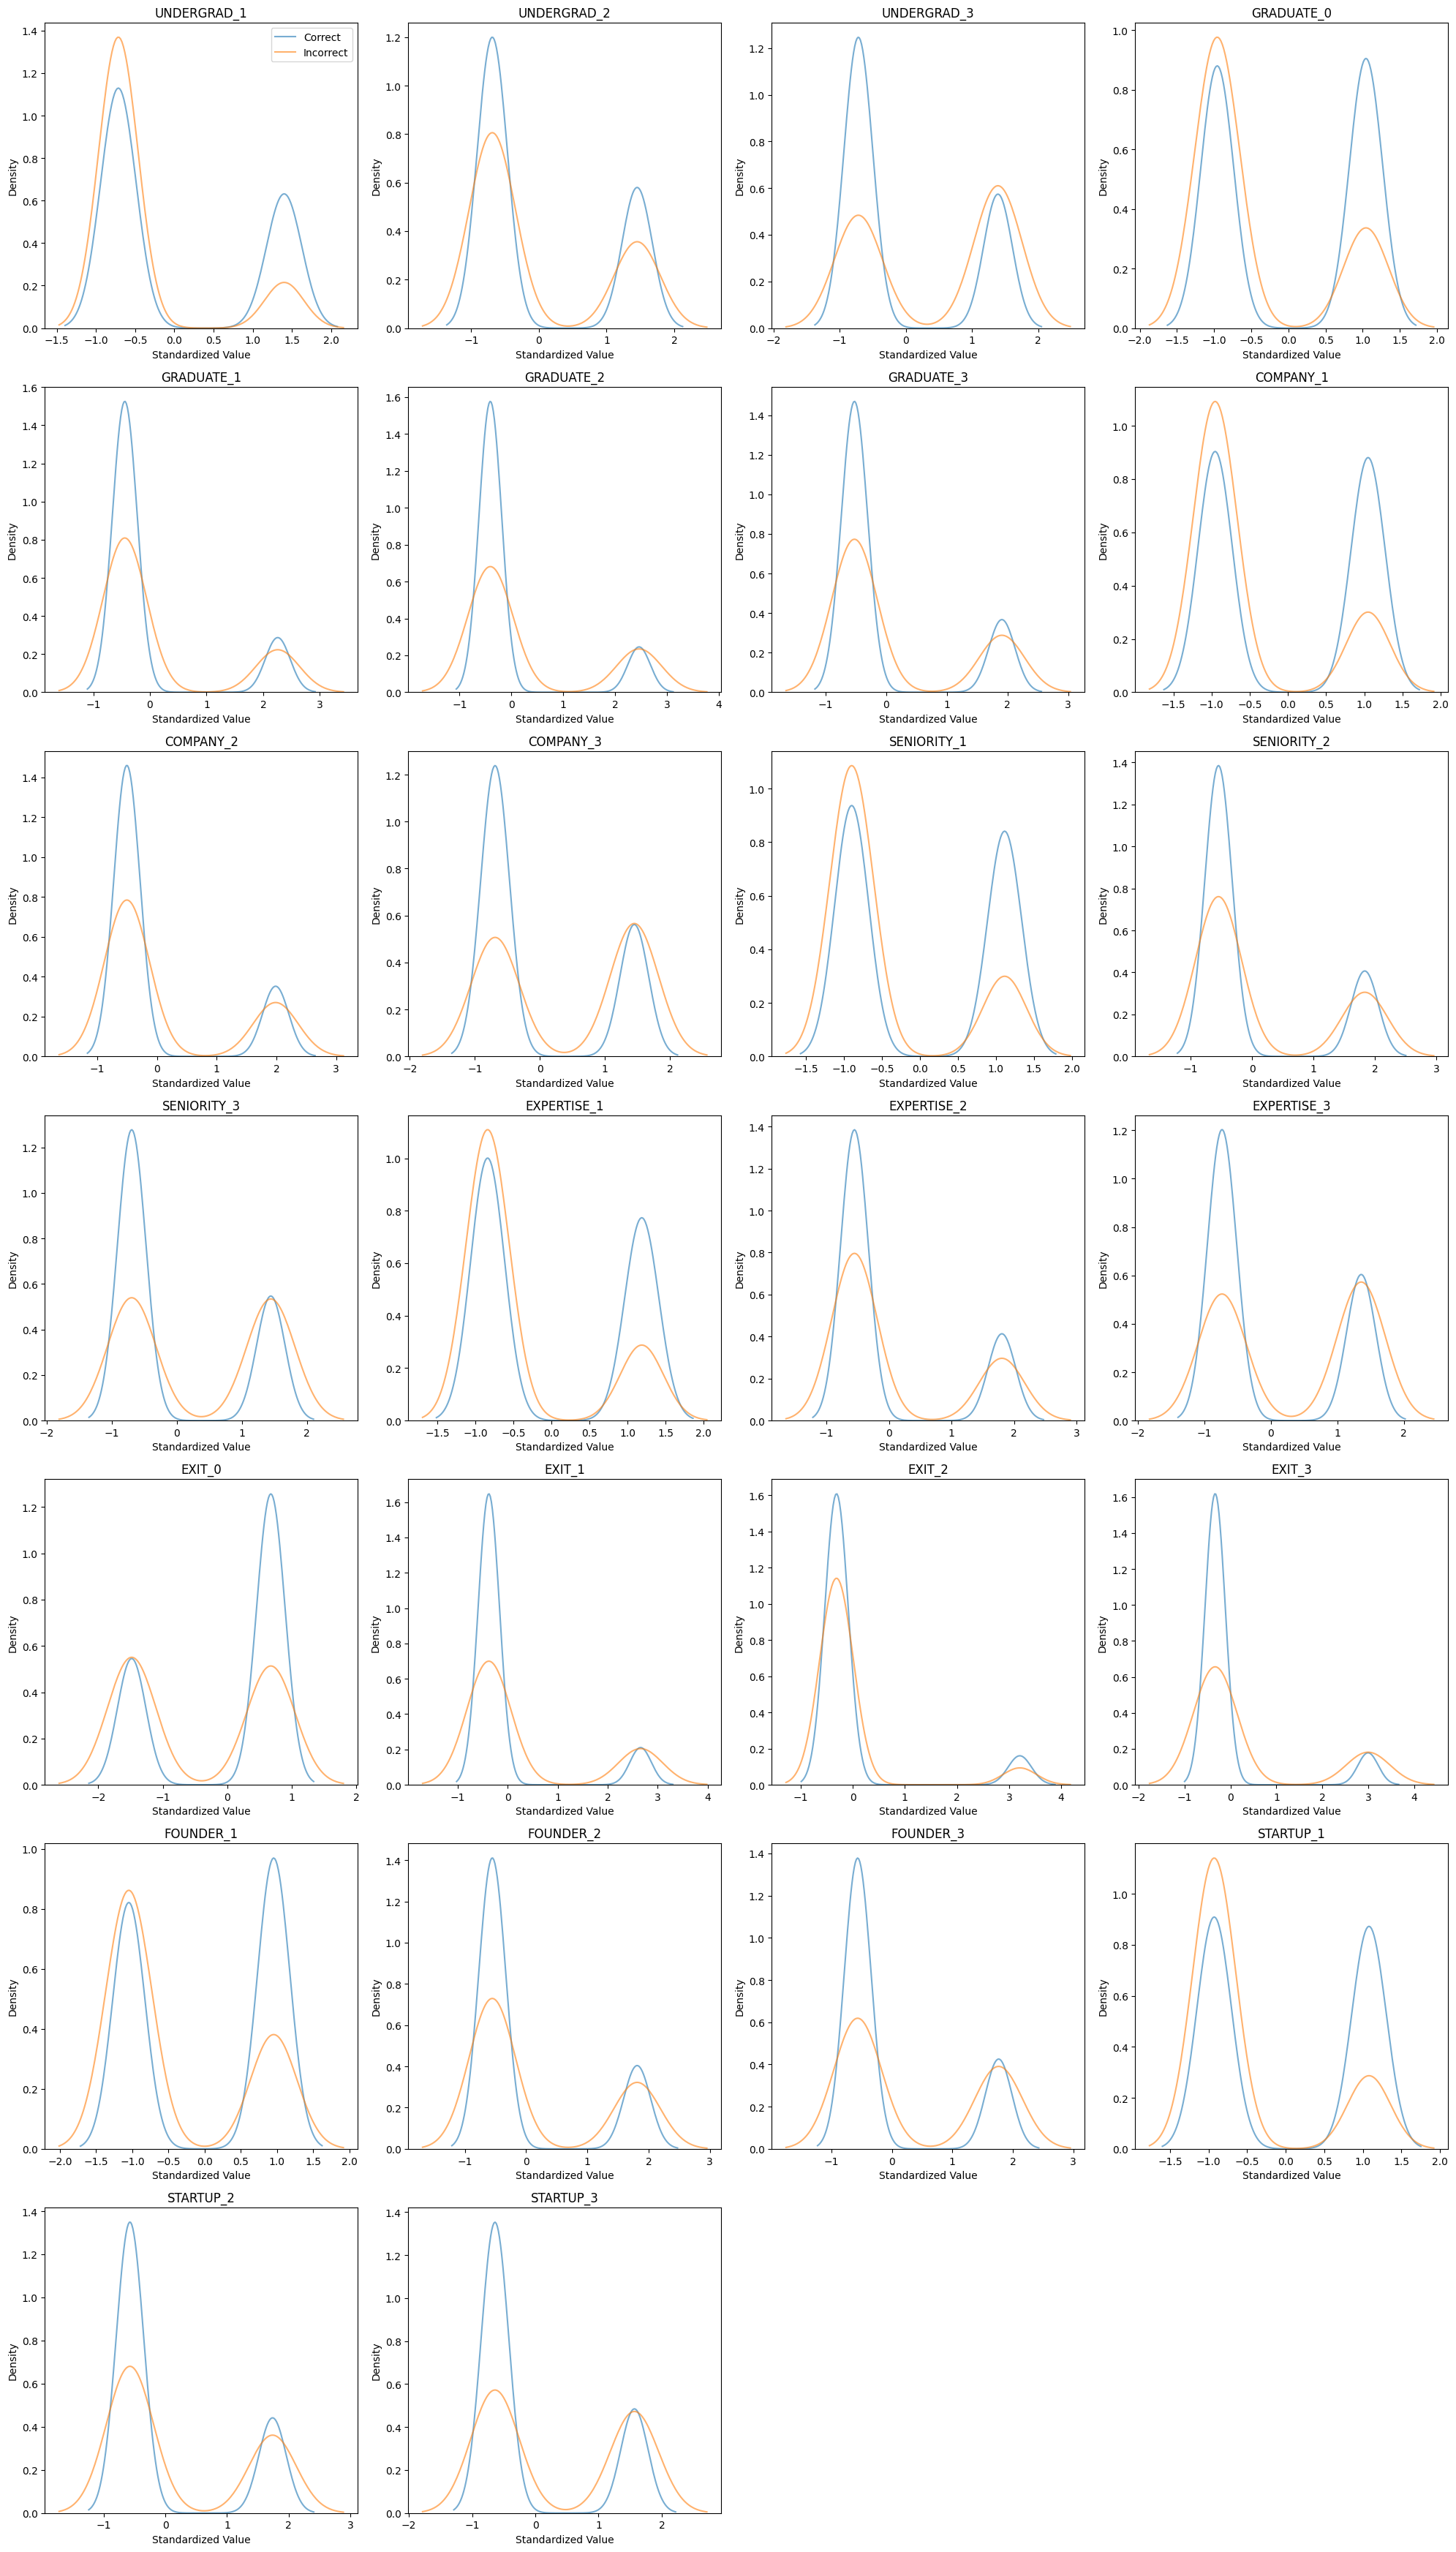


Feature Means for High Confidence Predictions:
             High Conf Correct  High Conf Incorrect  All Data
UNDERGRAD_1              0.495               -0.350    -0.003
UNDERGRAD_2             -0.185               -0.246     0.005
UNDERGRAD_3             -0.311                0.592    -0.002
GRADUATE_0               0.552               -0.268     0.007
GRADUATE_1              -0.203                0.581    -0.001
GRADUATE_2              -0.254               -0.307     0.016
GRADUATE_3              -0.272                0.062    -0.021
COMPANY_1                0.442               -0.401    -0.020
COMPANY_2               -0.229                0.527    -0.004
COMPANY_3               -0.276               -0.024     0.025
SENIORITY_1              0.551               -0.551     0.003
SENIORITY_2             -0.264                0.274     0.008
SENIORITY_3             -0.349                0.339    -0.010
EXPERTISE_1              0.690               -0.281    -0.003
EXPERTISE_2           

In [45]:
# Get model predictions and confidence (same as before)
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(config['device'])
    logits = model(X_test_tensor)
    probs = torch.sigmoid(logits).cpu().numpy()
    preds = (probs > 0.5).astype(int)

analysis_df = pd.DataFrame(X_test, columns=feature_names)
analysis_df['true_label'] = y_test
analysis_df['predicted'] = preds
analysis_df['confidence'] = np.abs(probs - 0.5) + 0.5
analysis_df['correct'] = analysis_df['true_label'] == analysis_df['predicted']

# Calculate number of rows needed (assuming 4 plots per row)
n_features = len(feature_names)
n_rows = (n_features + 3) // 4  # Ceiling division by 4

# Create larger figure
plt.figure(figsize=(20, 5 * n_rows))

for i, feature in enumerate(feature_names):
    plt.subplot(n_rows, 4, i+1)
    sns.kdeplot(data=analysis_df[analysis_df['correct']], x=feature, label='Correct', alpha=0.6)
    sns.kdeplot(data=analysis_df[~analysis_df['correct']], x=feature, label='Incorrect', alpha=0.6)
    plt.title(f'{feature}')
    plt.xlabel('Standardized Value')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

# Calculate and show means for all features
confidence_threshold = np.percentile(analysis_df['confidence'], 75)
high_conf_correct = analysis_df[
    (analysis_df['correct']) & 
    (analysis_df['confidence'] >= confidence_threshold)
]
high_conf_incorrect = analysis_df[
    (~analysis_df['correct']) & 
    (analysis_df['confidence'] >= confidence_threshold)
]

comparison_df = pd.DataFrame({
    'High Conf Correct': high_conf_correct[feature_names].mean(),
    'High Conf Incorrect': high_conf_incorrect[feature_names].mean(),
    'All Data': analysis_df[feature_names].mean()
}).round(3)

print("\nFeature Means for High Confidence Predictions:")
print(comparison_df)